### General Imports and Prep
Import the necessary libraries and prepare the image imports

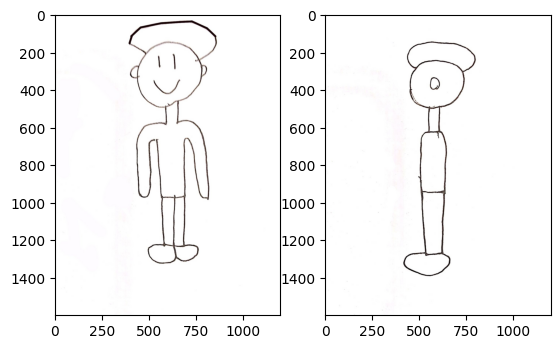

In [15]:
import cv2
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from scipy.interpolate import splprep, splev
from skimage import measure
from scipy.spatial import ConvexHull

# Function to move points towards the center
def move_points_towards_center(points, center, step, threshold, edge_points):
    moved_points = []
    for point in points:
        while True:
            if np.any(np.all(np.isclose(edge_points, point, atol=threshold), axis=1)):
                break
            if abs(point[1] - center[1]) <= threshold:
                break
            if point[1] > center[1]:
                point[1] -= step
            else:
                point[1] += step
        moved_points.append(point)
    return np.array(moved_points)

# Function to fill gaps between points
def fill_gaps(points):
    filled_points = []
    for i in range(points.shape[1] - 1):
        start = points[:, i]
        end = points[:, i + 1]
        filled_points.append(start)
        while not np.array_equal(start, end):
            if start[0] < end[0]:
                start[0] += 1
            elif start[0] > end[0]:
                start[0] -= 1
            if start[1] < end[1]:
                start[1] += 1
            elif start[1] > end[1]:
                start[1] -= 1
            filled_points.append(start.copy())
    filled_points.append(points[:, -1])
    return np.array(filled_points).T

obj_front = cv2.imread("drawings/man-front.jpg")
obj_right = cv2.imread("drawings/man-right.jpg")
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(obj_front, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(obj_right, cv2.COLOR_BGR2RGB))
plt.show()

### Image Pre-processing
Binary threshold the images, and apply an edge detection algorithm to extract the lines

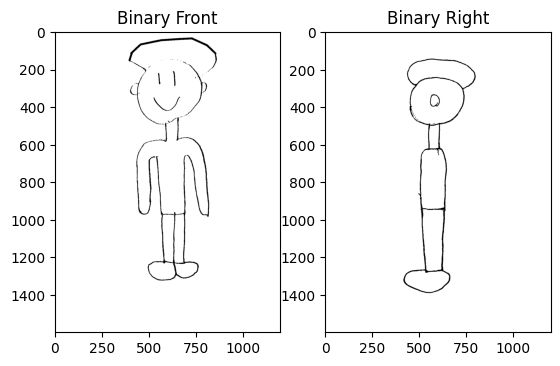

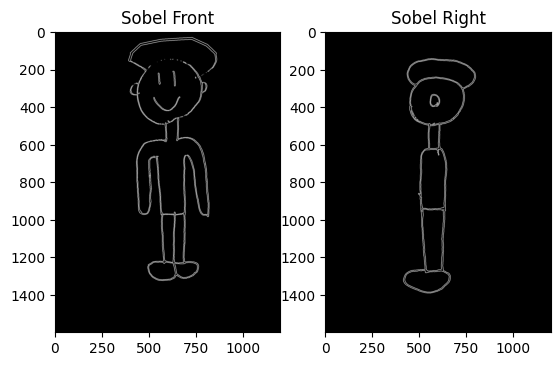

In [16]:
# Convert the image to grayscale
gray_obj_front = cv2.cvtColor(obj_front, cv2.COLOR_BGR2GRAY)
gray_obj_right = cv2.cvtColor(obj_right, cv2.COLOR_BGR2GRAY)

# Apply binary thresholding
_, binary_obj_front = cv2.threshold(gray_obj_front, 127, 255, cv2.THRESH_BINARY)
_, binary_obj_right = cv2.threshold(gray_obj_right, 127, 255, cv2.THRESH_BINARY)

# Apply Sobel operator to find edges
sobelx = cv2.Sobel(binary_obj_front, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(binary_obj_front, cv2.CV_64F, 0, 1, ksize=5)
sobel_edges_front = np.sqrt(sobelx**2 + sobely**2)
sobelx = cv2.Sobel(binary_obj_right, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(binary_obj_right, cv2.CV_64F, 0, 1, ksize=5)
sobel_edges_right = np.sqrt(sobelx**2 + sobely**2)

plt.subplot(1, 2, 1)
plt.imshow(binary_obj_front, cmap="gray"); plt.title("Binary Front")
plt.subplot(1, 2, 2)
plt.imshow(binary_obj_right, cmap="gray"); plt.title("Binary Right")
plt.show()
plt.subplot(1, 2, 1)
plt.imshow(sobel_edges_front, cmap="gray"); plt.title("Sobel Front")
plt.subplot(1, 2, 2)
plt.imshow(sobel_edges_right, cmap="gray"); plt.title("Sobel Right")
plt.show()


### Use the Convex Hull Algorithm To Simplify the Shape
Using the CVH algorithm, find the smallest line that encircles the entire image

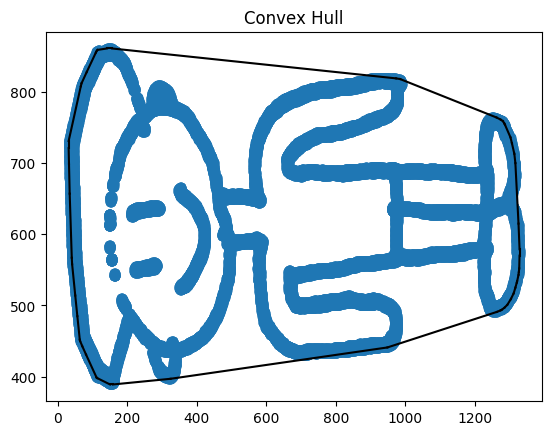

In [17]:
points_front = np.column_stack(np.where(sobel_edges_front > 0))
hull_front = ConvexHull(points_front)
plt.plot(points_front[:, 0], points_front[:, 1], "o")
plt.title('Points in the image')
for simplex in hull_front.simplices:
    plt.plot(points_front[simplex, 0], points_front[simplex, 1], 'k-')
plt.title('Convex Hull')

plt.show()

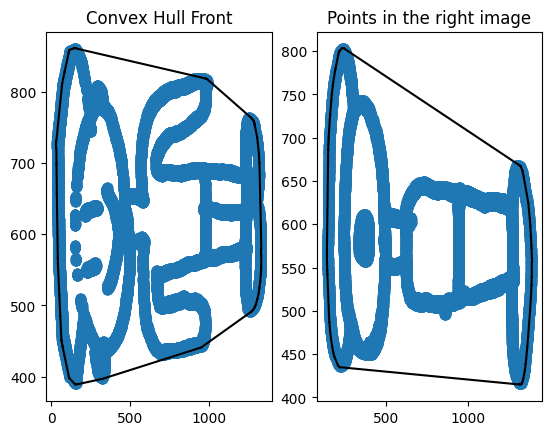

In [18]:
# Reorder the points to make them compatible with the convex hull function
points_front = np.column_stack(np.where(sobel_edges_front > 0))
points_right = np.column_stack(np.where(sobel_edges_right > 0))

# Find the convex hull of the points
hull_front = ConvexHull(points_front)
hull_right = ConvexHull(points_right)

plt.subplot(1, 2, 1)
plt.plot(points_front[:,0], points_front[:,1], 'o'); plt.title('Points in the front image')
for simplex in hull_front.simplices:
    plt.plot(points_front[simplex, 0], points_front[simplex, 1], 'k-')
plt.title('Convex Hull Front')
plt.subplot(1, 2, 2)
plt.plot(points_right[:,0], points_right[:,1], 'o'); plt.title('Points in the right image')
for simplex in hull_right.simplices:
    plt.plot(points_right[simplex, 0], points_right[simplex, 1], 'k-')
plt.show()

### Find the center and align the images
Find the center of each hull, and scale the side view to match the same width as the front view. 

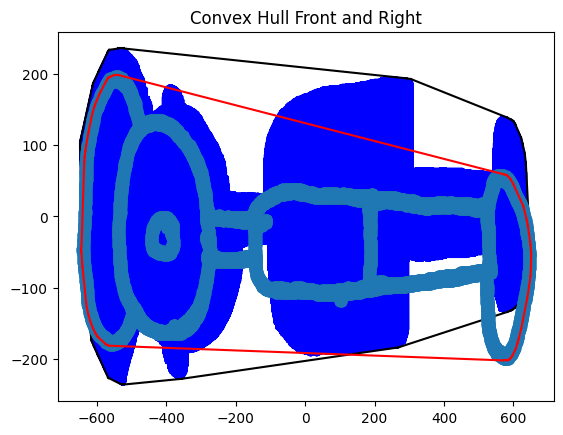

In [29]:
# Find the center of the points
x1 = hull_front.max_bound[0] - hull_front.min_bound[0]
y1 = hull_front.max_bound[1] - hull_front.min_bound[1]
center_front = (x1//2 + hull_front.min_bound[0], y1//2 + hull_front.min_bound[1])
x2 = hull_right.max_bound[0] - hull_right.min_bound[0]
y2 = hull_right.max_bound[1] - hull_right.min_bound[1]
center_right = (x2//2 + hull_right.min_bound[0], y2//2 + hull_right.min_bound[1])

# Re-align the points to the center
trans_front = points_front - center_front
trans_right = points_right - center_right
center = np.array([0, 0]) # Now that the images are centered, the center of both is at (0,0)

# Determine the scale factor
scale_factor = x1 / x2

# Scale the right view points to match the front view and recalculate the hull
scaled_points_right = trans_right * scale_factor
hull_right = ConvexHull(scaled_points_right)

plt.plot(trans_front[:,0], trans_front[:,1], 'b'); plt.title('Points in the front image')
for simplex in hull_front.simplices:
    plt.plot(trans_front[simplex, 0], trans_front[simplex, 1], 'k-')
plt.plot(scaled_points_right[:,0], scaled_points_right[:,1], 'o')
for simplex in hull_right.simplices:
    plt.plot(scaled_points_right[simplex, 0], scaled_points_right[simplex, 1], 'r-')
plt.title('Convex Hull Front and Right')   
plt.show()

### Interpolate the hull
Treating the hull as a spline, convert it to a set of points.
We can cheat a bit by only doing the next few steps for the front view

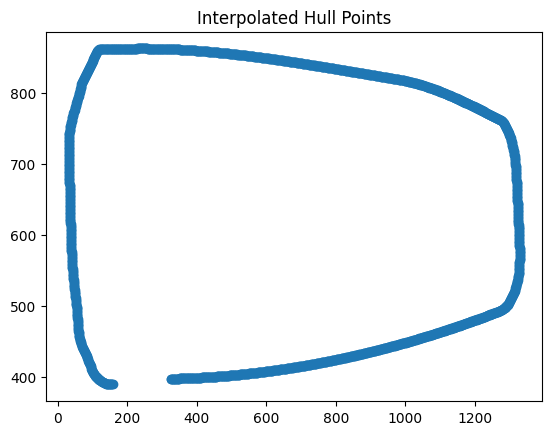

In [30]:
# Extract the hull points
hull_points = points_front[hull_front.vertices]

# Create a parameterization of the hull points
tck, u = splprep([hull_points[:, 0], hull_points[:, 1]], s=0)

# Define the number of points you want on the hull
num_points = 1500

# Generate new points on the hull
new_points = splev(np.linspace(0, 1, num_points), tck)

# Convert the new points to a numpy array
new_hull_points = np.column_stack(new_points)

# Plot the new hull points
plt.plot(new_hull_points[:, 0], new_hull_points[:, 1], 'o')
plt.title('Interpolated Hull Points')
plt.show()